# Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import textwrap
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../../../src')) # Add the src directory to the Python path

from pisadatamap.pisadatamap import PISADataMap

data_map = PISADataMap([
    '../../../databases/2018/teacher_data_structure_2018.csv'
])

sns.set_theme()

#df = pd.read_csv("../../../databases/q2_database_teacher.csv")

df = pd.read_csv('../../../databases/2018/formated_by_teacher2018.csv')

# 4. Modelling

In [2]:
def categorize_reading_students_by_performance(df):
    # Sort the DataFrame by 'Avg Reading Result' in descending order
    df = df.sort_values(by='Avg Reading Result', ascending=False).reset_index(drop=True)

    # Calculate the number of students
    total_students = len(df)

    # Define the percentage thresholds
    very_good_threshold = int(total_students * 0.70)
    neutral_threshold = int(total_students * 0.50)

    # Assign categories from highest to lowest
    df.loc[0:neutral_threshold-1, 'Reading Score Classification'] = 0
    df.loc[neutral_threshold:very_good_threshold-1, 'Reading Score Classification'] = 1
    df.loc[very_good_threshold:, 'Reading Score Classification'] = 2

    return df
df = categorize_reading_students_by_performance(df)
df.sample(5)

,CNTTCHID,total_students,total_repeaters,Avg Reading Result,Avg Math Result,Avg Science Result,CNTRYID,CNT,CNTSCHID,TEACHERID,...,TCDISCLIMA,TCDIRINS,FEEDBACK,ADAPTINSTR,FEEDBINSTR,TCATTIMM,GCTRAIN,TCMCEG,GCSELF,Reading Score Classification
90563,62000853.0,13,4.0,372.160831,428.062785,410.434685,620.0,b'PRT',62000168.0,4.0,...,-0.2722,-0.2514,NaN,-2.5712,-0.1045,NaN,NaN,NaN,NaN,2.0
45684,72412738.0,39,15.0,474.185264,462.422192,470.840282,724.0,b'ESP',72400820.0,4.0,...,-0.0853,1.3596,NaN,1.1865,0.9909,NaN,NaN,NaN,NaN,0.0
24443,72405107.0,37,6.0,513.202057,505.451622,509.898719,724.0,b'ESP',72400841.0,5.0,...,NaN,NaN,-0.2065,NaN,NaN,0.6596,-1.3236,-0.1151,-0.2634,0.0
11809,27600853.0,25,2.0,543.455464,534.937920,529.230228,276.0,b'DEU',27600199.0,5.0,...,NaN,NaN,0.1974,NaN,NaN,-0.9760,1.0055,1.1250,-0.6702,0.0
84886,78401445.0,34,2.0,388.012468,430.056182,441.052024,784.0,b'ARE',78400262.0,5.0,...,NaN,NaN,-1.4326,NaN,NaN,NaN,-1.3236,NaN,NaN,2.0


In [3]:
y = df["Avg Reading Result"]
X = df.drop(columns=["Avg Reading Result"])

class_col = X["Reading Score Classification"]
X = X.drop(columns=["Reading Score Classification"])


### Step 1 - Pre-process

We began by pre-processing the dataset, to ensure it was suitable for use in the selected models.


In [4]:
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

numerical_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    [
        ("num", numerical_transformer, numerical_cols),
    ]
)

X_encoded = preprocessor.fit_transform(X)

final_columns = list(numerical_cols)

X_encoded_df = pd.DataFrame(X_encoded, columns=final_columns)

X_encoded_df["Reading Score Classification"] = class_col.reset_index(drop=True)

X_encoded_best = X_encoded_df[X_encoded_df["Reading Score Classification"] == 2].drop(columns=["Reading Score Classification"])
X_encoded_neutral = X_encoded_df[X_encoded_df["Reading Score Classification"] == 1].drop(columns=["Reading Score Classification"])
X_encoded_worst = X_encoded_df[X_encoded_df["Reading Score Classification"] == 0].drop(columns=["Reading Score Classification"])


### Step 2 – K-Means

As a second step, we applied an unsupervised learning technique — K-Means clustering — to group the data into three clusters. This approach allowed us to identify patterns and similarities among students, enabling a better understanding of the different profiles that may influence reading performance.

We separated them in 3 groups, Best, neutral and worst, in order to compare how the profiles differ between these 3.


In [5]:
kmeans_best = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_best)
kmeans_neutral = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_neutral)
kmeans_worst = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_worst)

In [6]:
best = df[df["Reading Score Classification"] == 2].reset_index(drop=True)
best["kmeans"] = kmeans_best.labels_
X_encoded_best["kmeans"] = kmeans_best.labels_

neutral = df[df["Reading Score Classification"] == 1].reset_index(drop=True)
neutral["kmeans"] = kmeans_neutral.labels_
X_encoded_neutral["kmeans"] = kmeans_neutral.labels_

worst = df[df["Reading Score Classification"] == 0].reset_index(drop=True)
worst["kmeans"] = kmeans_worst.labels_
X_encoded_worst["kmeans"] = kmeans_worst.labels_

print(best.groupby("kmeans")["Avg Reading Result"].describe().to_string())
print(neutral.groupby("kmeans")["Avg Reading Result"].describe().to_string())
print(worst.groupby("kmeans")["Avg Reading Result"].describe().to_string())

          count       mean        std         min         25%         50%         75%         max
kmeans                                                                                           
0       17400.0  362.14743  35.854756  200.758600  339.465666  368.571776  391.673982  410.324066
1        7011.0  362.07404  36.429588  224.937262  337.483642  369.209726  391.837920  410.324066
2        7800.0  362.09200  37.336807  200.758600  337.815400  373.045718  392.073435  410.306400
          count        mean        std         min         25%         50%         75%         max
kmeans                                                                                            
0        5862.0  435.987803  13.857456  410.324066  423.584632  436.678673  448.164688  459.368845
1       13829.0  434.779600  13.936170  410.324066  423.022118  435.300795  446.447562  459.368845
2        1782.0  436.398203  13.884975  410.462883  423.651757  437.563226  449.171854  459.368845
          count

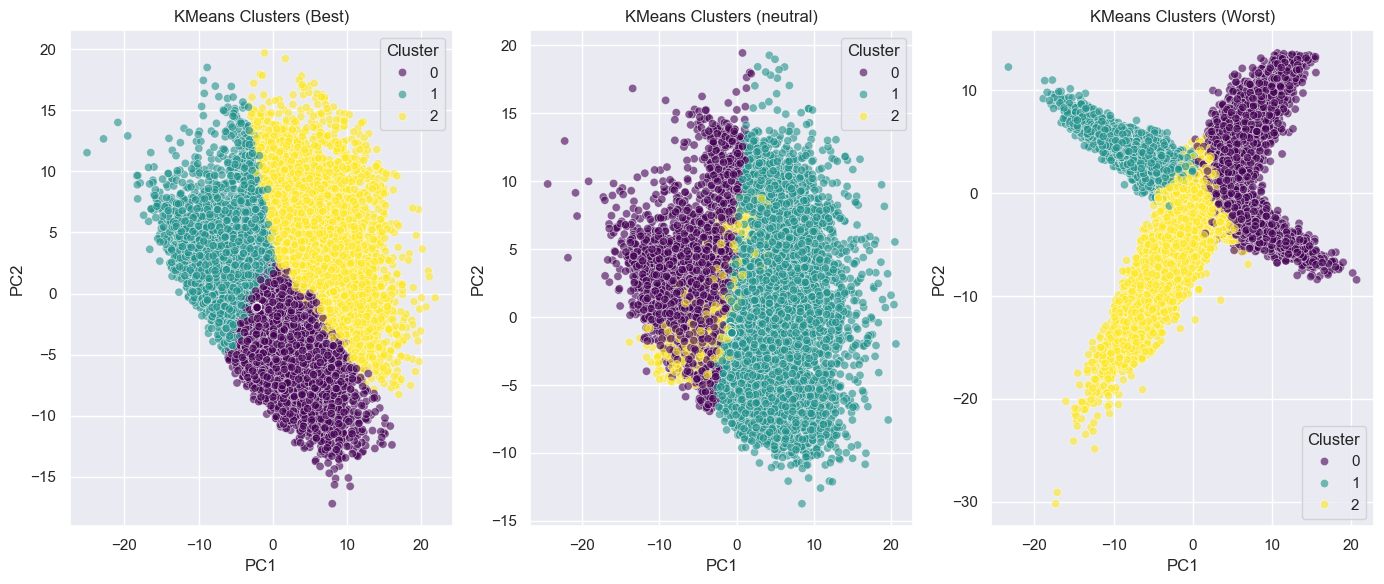

In [7]:
# best pca
pca_best = PCA(n_components=2)
X_pca_best = pca_best.fit_transform(X_encoded_best)
X_pca_best_df = pd.DataFrame(X_pca_best, columns=["PC1", "PC2"])
X_pca_best_df["Cluster"] = kmeans_best.labels_

# neutral pca
pca_neutral = PCA(n_components=2)
X_pca_neutral = pca_neutral.fit_transform(X_encoded_neutral)
X_pca_neutral_df = pd.DataFrame(X_pca_neutral, columns=["PC1", "PC2"])
X_pca_neutral_df["Cluster"] = kmeans_neutral.labels_

# neutral pca
pca_worst = PCA(n_components=2)
X_pca_worst = pca_worst.fit_transform(X_encoded_worst)
X_pca_worst_df = pd.DataFrame(X_pca_worst, columns=["PC1", "PC2"])
X_pca_worst_df["Cluster"] = kmeans_worst.labels_


fig, axes = plt.subplots(1, 3, figsize=(14, 6))

sns.scatterplot(
    data=X_pca_best_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Best)")

sns.scatterplot(
    data=X_pca_neutral_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (neutral)")

sns.scatterplot(
    data=X_pca_worst_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[2],
)
axes[2].set_title("KMeans Clusters (Worst)")

plt.tight_layout()
plt.show()

Ordenar os rótulos por média:

In [8]:
#best
means = best.groupby("kmeans")["Avg Reading Result"].mean()
ordered_labels_vg = means.sort_values().index.tolist()

label_map = {old_label: new_label for new_label, old_label in enumerate(ordered_labels_vg)}

best["kmeans"] = best["kmeans"].map(label_map)
X_encoded_best["kmeans"] = X_encoded_best["kmeans"].map(label_map)

#neutral
means_neutral = neutral.groupby("kmeans")["Avg Reading Result"].mean()
ordered_labels_neutral = means_neutral.sort_values().index.tolist()
label_map_neutral = {
    old_label: new_label for new_label, old_label in enumerate(ordered_labels_neutral)
}
neutral["kmeans"] = neutral["kmeans"].map(label_map_neutral)
X_encoded_neutral["kmeans"] = X_encoded_neutral["kmeans"].map(
    label_map_neutral
)

#worst
means_worst = worst.groupby("kmeans")["Avg Reading Result"].mean()
ordered_labels_worst = means_worst.sort_values().index.tolist()
label_map_worst = {
    old_label: new_label for new_label, old_label in enumerate(ordered_labels_worst)
}
worst["kmeans"] = worst["kmeans"].map(label_map_worst)
X_encoded_worst["kmeans"] = X_encoded_worst["kmeans"].map(
    label_map_worst
)

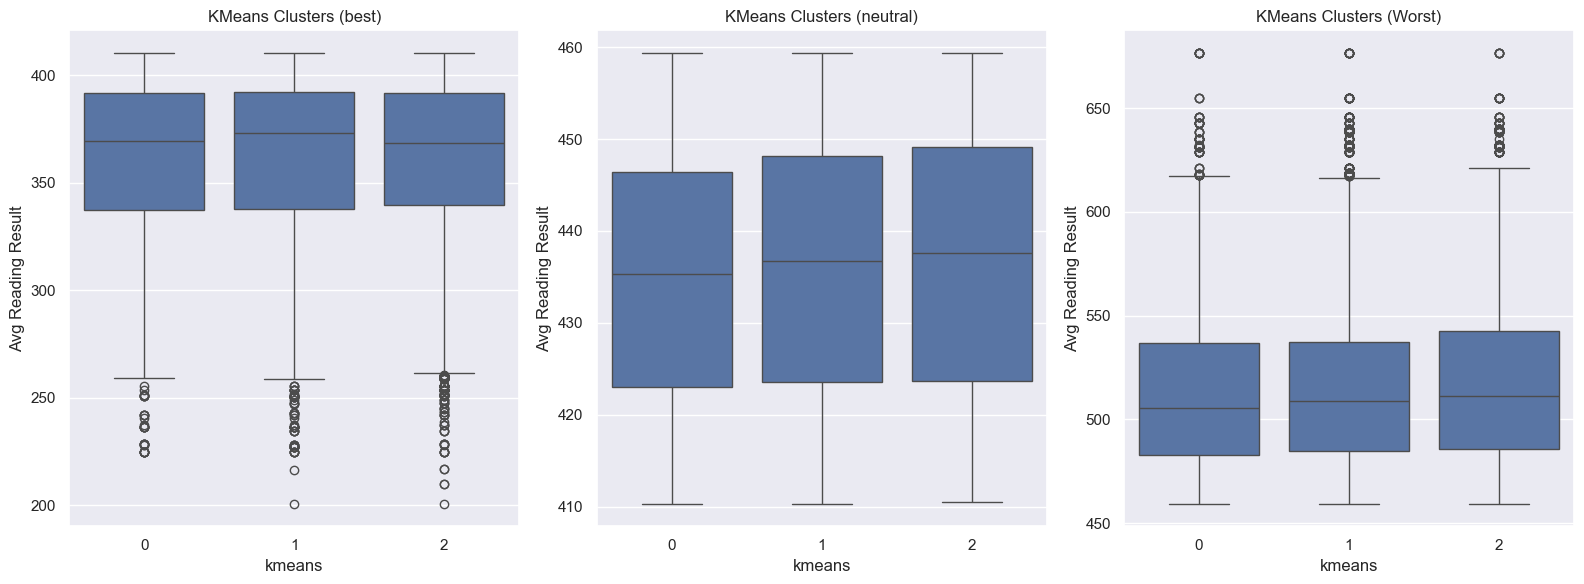

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.boxplot(
    data=best,
    x="kmeans",
    y="Avg Reading Result",
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (best)")

sns.boxplot(
    data=neutral,
    x="kmeans",
    y="Avg Reading Result",
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (neutral)")


sns.boxplot(
    data=worst,
    x="kmeans",
    y="Avg Reading Result",
    ax=axes[2],
)
axes[2].set_title("KMeans Clusters (Worst)")

plt.tight_layout()
plt.show()

TODO: Avaliar quais destes gráficos podem ser interessantes para mostrar

Because the correlations do not say much, we we'll compute the top fewatures to show
Porque não sabemos que features têm mais importancia,

In [10]:
target_column = 'Reading Score Classification'
if target_column not in df.columns:
    print(f"ERRO: A coluna alvo '{target_column}' não existe no DataFrame.")
    exit()
y = df[target_column]
columns_to_drop = [
    'Reading Score Classification', 'Avg Reading Result', 'Avg Math Result', 'Avg Science Result',
    'CNTTCHID', 'TEACHERID', 'CNT'
]
existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
X = df.drop(columns=existing_cols_to_drop)


# --- PASSO 2: Limpeza Automática dos Dados ---
# ... (código igual ao anterior) ...
print("\n--- A iniciar a limpeza dos dados ---")
X_numeric = X.select_dtypes(include=np.number)
limiar = len(X_numeric) * 0.5
X_numeric = X_numeric.dropna(axis=1, thresh=limiar)
constant_cols = [col for col in X_numeric.columns if X_numeric[col].nunique() <= 1]
if constant_cols:
    X_numeric = X_numeric.drop(columns=constant_cols)
X_clean = X_numeric.fillna(X_numeric.median())


# --- PASSO 3: Treinar o Modelo Random Forest ---
# ... (código igual ao anterior) ...
model = RandomForestClassifier(
    n_estimators=150, random_state=42, class_weight='balanced', n_jobs=-1
)
print("\nA treinar o modelo Random Forest com todos os dados...")
model.fit(X_clean, y)
print("Treino concluído.")


# --- PASSO 4: Obter e Apresentar as Features Mais Importantes ---
# ... (código igual ao anterior) ...
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_clean.columns,
    'Importance': importances
})
top_20_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
print("\n\n--- AS 20 ESTRATÉGIAS/CARACTERÍSTICAS DE PROFESSORES MAIS INFLUENTES ---")
print(top_20_features)


# --- PASSO 5: Analisar e Interpretar os Resultados (VERSÃO CORRIGIDA E ROBUSTA) ---

top_5_feature_names = top_20_features.head(20)['Feature'].tolist()


--- A iniciar a limpeza dos dados ---

A treinar o modelo Random Forest com todos os dados...
Treino concluído.


--- AS 20 ESTRATÉGIAS/CARACTERÍSTICAS DE PROFESSORES MAIS INFLUENTES ---
             Feature  Importance
3           CNTSCHID    0.091821
1    total_repeaters    0.066457
0     total_students    0.064905
5               OECD    0.045086
4             Region    0.041920
2            CNTRYID    0.030745
7         TC002Q01NA    0.012945
10        TC007Q02NA    0.012704
9         TC007Q01NA    0.011965
241        TCOTLCOMP    0.011907
238         SATTEACH    0.010224
237           SATJOB    0.009520
115       TC176Q01HA    0.008286
242         TCICTUSE    0.008053
236            EXCHT    0.007492
235       TCEDUSHORT    0.007371
234     TCSTAFFSHORT    0.006899
240          SEFFINS    0.006587
243         FEEDBACK    0.006183
100       TC164Q01HA    0.005921


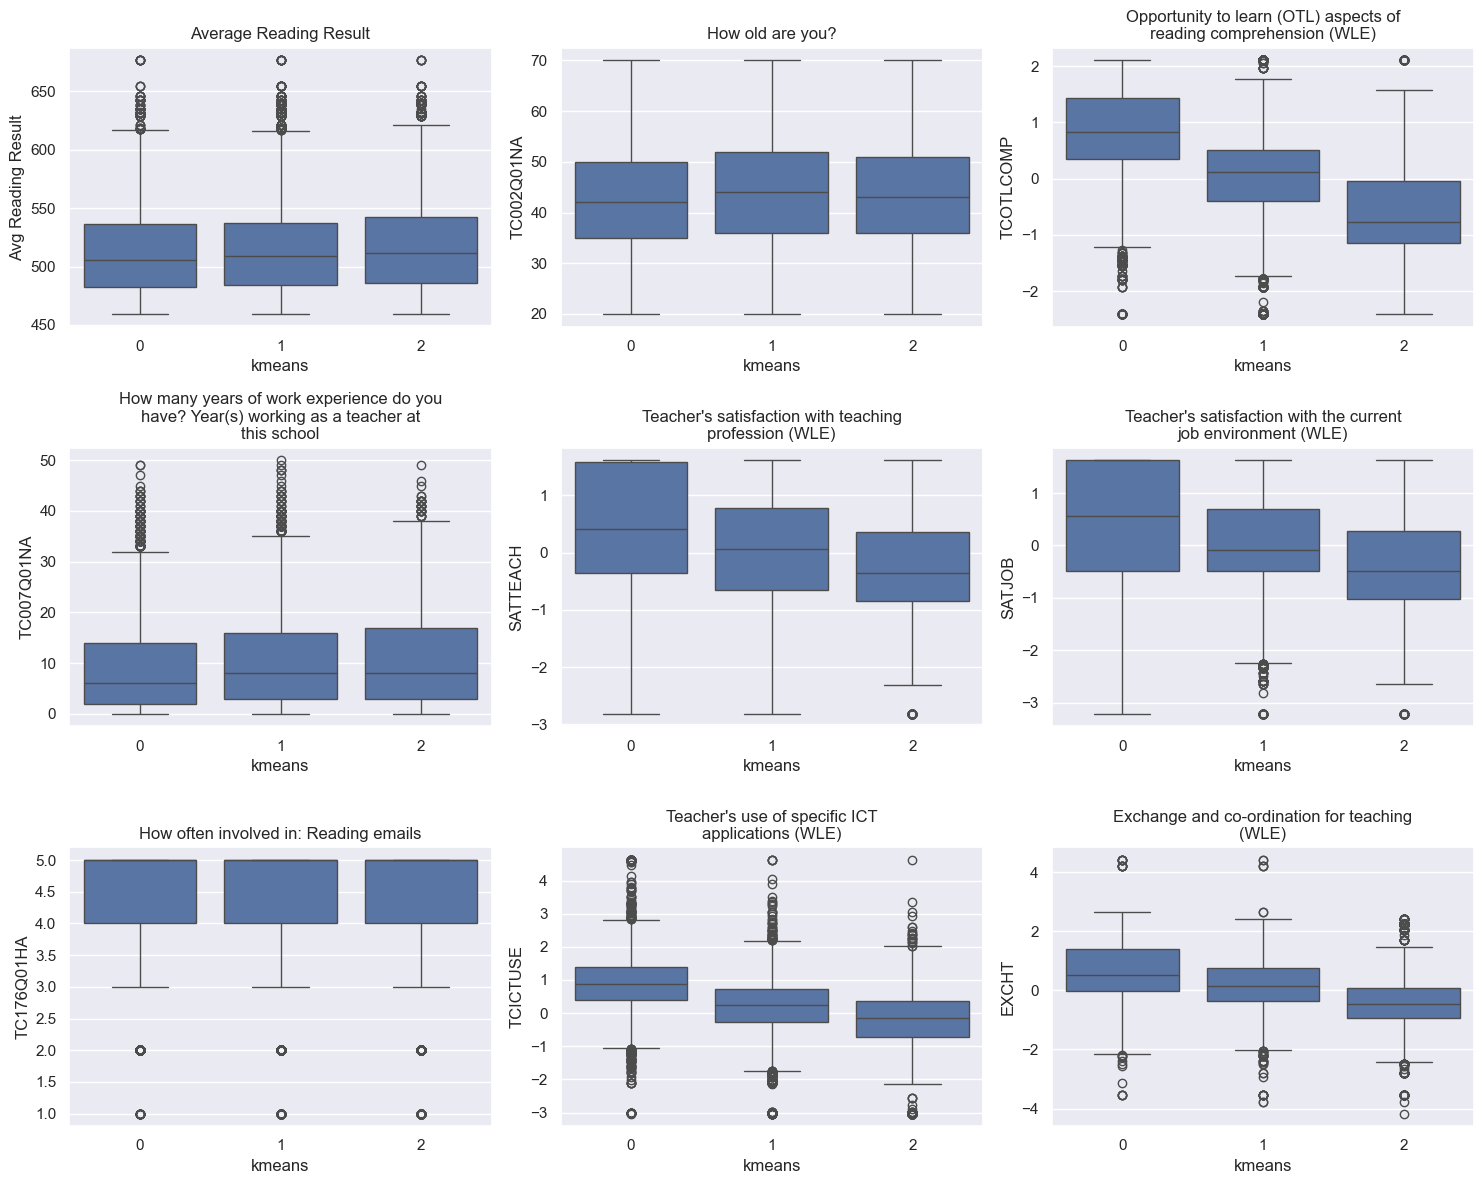

In [11]:

columns_to_plot = [
    "Avg Reading Result",
    "TC002Q01NA",
    "TCOTLCOMP",
    "TC007Q01NA",
    "SATTEACH",
    "SATJOB",
    "TC176Q01HA",
    "TCICTUSE",
    "EXCHT"
]

n_cols = 3
n_rows = -(-len(columns_to_plot) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=worst, x="kmeans", y=column, ax=axes[i])
    title = data_map.get(column)
    wrapped_title = "\n".join(textwrap.wrap(title, width=40))
    axes[i].set_title(wrapped_title)
    axes[i].tick_params(axis="x")

for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
centroids_best = pd.DataFrame(
    kmeans_best.cluster_centers_,
    columns=X_encoded_best.drop(columns="kmeans").columns,
)
print(centroids_best.to_string())

   CNTTCHID  total_students  total_repeaters  Avg Math Result  Avg Science Result   CNTRYID  CNTSCHID  TEACHERID    Region      OECD  TC001Q01NA  TC002Q01NA  TC005Q01NA  TC007Q01NA  TC007Q02NA  TC014Q01HA  TC015Q01NA  TC018Q01NA  TC018Q01NB  TC018Q02NA  TC018Q02NB  TC018Q03NA  TC018Q03NB  TC018Q04NA  TC018Q04NB  TC018Q05NA  TC018Q05NB  TC018Q06NA  TC018Q06NB  TC018Q07NA  TC018Q07NB  TC018Q08NA  TC018Q08NB  TC018Q09NA  TC018Q09NB  TC018Q10NA  TC018Q10NB  TC018Q11NA  TC018Q11NB  TC045Q01NA  TC045Q01NB  TC045Q02NA  TC045Q02NB  TC045Q03NA  TC045Q03NB  TC045Q04NA  TC045Q04NB  TC045Q05NA  TC045Q05NB  TC045Q06NA  TC045Q06NB  TC045Q07NA  TC045Q07NB  TC045Q08NA  TC045Q08NB  TC045Q09NA  TC045Q09NB  TC045Q10NA  TC045Q10NB  TC045Q11NA  TC045Q11NB  TC045Q12NA  TC045Q12NB  TC045Q13NA  TC045Q13NB  TC045Q14NA  TC045Q14NB  TC045Q15NA  TC045Q15NB  TC045Q16HA  TC045Q16HB  TC045Q17HA  TC045Q17HB  TC045Q18HA  TC045Q18HB  TC021Q01NA  TC175Q01HA  TC198Q01HA  TC198Q02HA  TC198Q03HA  TC198Q04HA  TC198Q05HA  TC

### Step3 - Supervised Learning Approach (Random Forest Classifier)

In this step, we implemented another machine learning technique, this time a supervised learning approach, using a Random Forest Classifier. The main objective was to identify the most important features influencing teacher's strategies that best perform, not only for the entire dataset, but also for each of the clusters obtained in the previous step.

In [13]:
def plot_feature_importances(importance_df, cluster_id=None, mapping=data_map.as_dict()):
    melted_df = importance_df.reset_index().melt(
        id_vars="index", var_name="Group", value_name="Importance"
    )
    melted_df.rename(columns={"index": "Feature"}, inplace=True)

    melted_df["Feature"] = (
        melted_df["Feature"]
        .map(mapping)
        .fillna(melted_df["Feature"])
        .apply(lambda x: "\n".join(textwrap.wrap(x, 60)))
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted_df, y="Feature", x="Importance", hue="Group")
    if cluster_id is not None:
        plt.title(
            f"Top Feature Importances for Cluster {cluster_id} (Best vs Worst)"
        )
    else:
        plt.title(
            f"Top Feature Importances (Best vs Worst)"
        )
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()

Top features obtained for cluster 0, Best vs Worst

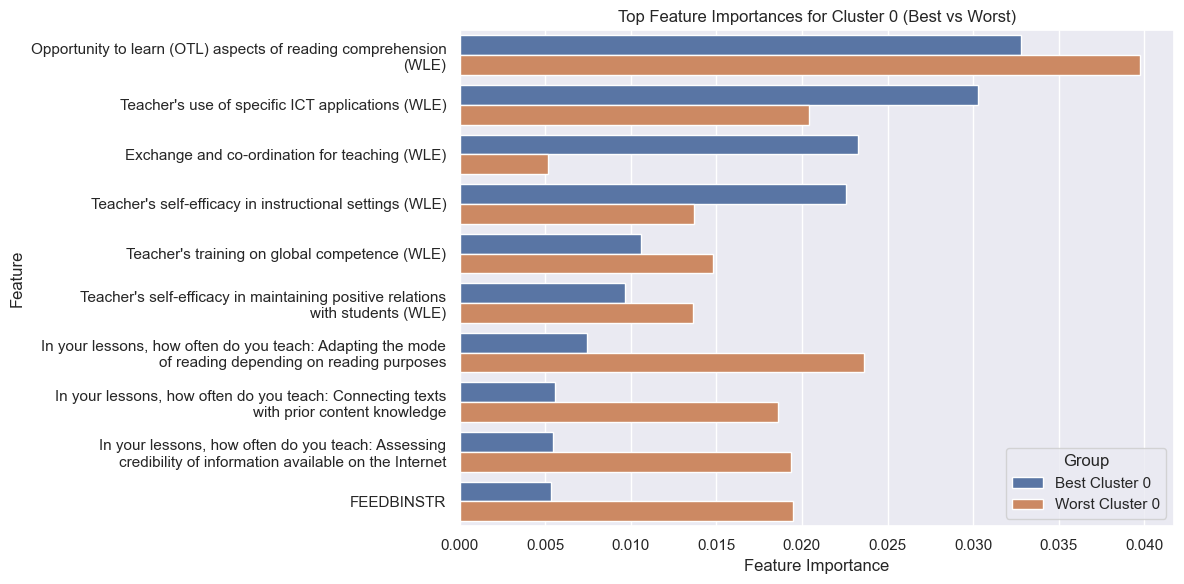

In [14]:
#Cluster 0
X_0_best = X_encoded_best.copy()
X_0_best["cluster_0"] = (X_0_best["kmeans"] == 0).astype(int)

X_best = X_0_best.drop(columns=["kmeans", "cluster_0"])
y_best = X_0_best["cluster_0"]

model_best = RandomForestClassifier(random_state=42)
model_best.fit(X_best, y_best)

importances_best = pd.Series(model_best.feature_importances_, index=X_best.columns)

## -------

#Cluster 0
X_0_worst = X_encoded_worst.copy()
X_0_worst["cluster_0"] = (X_0_worst["kmeans"] == 0).astype(int)

X_worst = X_0_worst.drop(columns=["kmeans", "cluster_0"])
y_worst = X_0_worst["cluster_0"]

model_worst = RandomForestClassifier(random_state=42)
model_worst.fit(X_worst, y_worst)

importances_worst = pd.Series(model_worst.feature_importances_, index=X_worst.columns)

importance_df = pd.DataFrame(
    {
        "Best Cluster 0": importances_best,
        "Worst Cluster 0": importances_worst,
    }
)

top_features = (
    (importances_best.abs() + importances_worst.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)

importance_df = importance_df.loc[top_features].sort_values(by="Best Cluster 0", ascending=False)

plot_feature_importances(importance_df, cluster_id=0)

Top features obtained for cluster 1, Best vs Worst

In [15]:
#Cluster 1
X_1_best = X_encoded_best.copy()
X_1_best["cluster_1"] = (X_1_best["kmeans"] == 1).astype(int)

X_best = X_1_best.drop(columns=["kmeans", "cluster_1"])
y_best = X_1_best["cluster_1"]

model_best = RandomForestClassifier(random_state=42)
model_best.fit(X_best, y_best)

importances_best = pd.Series(model_best.feature_importances_, index=X_best.columns)

#Cluster 1
X_1_neutral = X_encoded_neutral.copy()
X_1_neutral["cluster_1"] = (X_1_neutral["kmeans"] == 1).astype(int)

X_neutral = X_1_neutral.drop(columns=["kmeans", "cluster_1"])
y_neutral = X_1_neutral["cluster_1"]

model_neutral = RandomForestClassifier(random_state=42)
model_neutral.fit(X_neutral, y_neutral)

importances_neutral = pd.Series(model_neutral.feature_importances_, index=X_neutral.columns)

#Cluster 1
X_1_worst = X_encoded_worst.copy()
X_1_worst["cluster_1"] = (X_1_worst["kmeans"] == 1).astype(int)

X_worst = X_1_worst.drop(columns=["kmeans", "cluster_1"])
y_worst = X_1_worst["cluster_1"]

model_worst = RandomForestClassifier(random_state=42)
model_worst.fit(X_worst, y_worst)

importances_worst = pd.Series(model_worst.feature_importances_, index=X_worst.columns)

importance_df = pd.DataFrame(
    {
        "Best Cluster 1": importances_best,
        "Neutral Cluster 1": importances_neutral,
        "Worst Cluster 1": importances_worst,
    }
)

top_features = (
    (importances_best.abs() + importances_neutral.abs() + importances_worst.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Best Cluster 1", ascending=False)

print("\nTop Feature Importances for Cluster 1 (Best vs Neutral vs Worst):")
print(importance_df.round(4))


Top Feature Importances for Cluster 1 (Best vs Neutral vs Worst):
            Best Cluster 1  Neutral Cluster 1  Worst Cluster 1
STTMG8              0.0665             0.0016           0.0014
TC018Q08NA          0.0549             0.0009           0.0012
STTMG10             0.0532             0.0019           0.0017
TC018Q09NA          0.0496             0.0007           0.0011
NTEACH10            0.0492             0.0015           0.0015
STTMG9              0.0425             0.0007           0.0018
TCOTLCOMP           0.0021             0.0247           0.0230
SEFFINS             0.0018             0.0445           0.0218
SEFFREL             0.0012             0.0400           0.0109
TC199Q12HA          0.0007             0.0335           0.0107


Top features obtained for cluster 2, Best vs Worst


In [16]:
#Cluster 2
X_2_best = X_encoded_best.copy()
X_2_best["cluster_2"] = (X_2_best["kmeans"] == 2).astype(int)

X_best = X_2_best.drop(columns=["kmeans", "cluster_2"])
y_best = X_2_best["cluster_2"]

model_best = RandomForestClassifier(random_state=42)
model_best.fit(X_best, y_best)

importances_best = pd.Series(model_best.feature_importances_, index=X_best.columns)


#Cluster 2
X_2_neutral = X_encoded_neutral.copy()
X_2_neutral["cluster_2"] = (X_2_neutral["kmeans"] == 2).astype(int)

X_neutral = X_2_neutral.drop(columns=["kmeans", "cluster_2"])
y_neutral = X_2_neutral["cluster_2"]

model_neutral = RandomForestClassifier(random_state=42)
model_neutral.fit(X_neutral, y_neutral)

importances_neutral = pd.Series(model_neutral.feature_importances_, index=X_neutral.columns)

#Cluster 2
X_2_worst = X_encoded_worst.copy()
X_2_worst["cluster_2"] = (X_2_worst["kmeans"] == 2).astype(int)

X_worst = X_2_worst.drop(columns=["kmeans", "cluster_2"])
y_worst = X_2_worst["cluster_2"]

model_worst = RandomForestClassifier(random_state=42)
model_worst.fit(X_worst, y_worst)

importances_worst = pd.Series(model_worst.feature_importances_, index=X_worst.columns)

importance_df = pd.DataFrame(
    {
        "best Cluster 1": importances_best,
        "neutral Cluster 1": importances_neutral,
        "Worst Cluster 1": importances_worst,
    }
)

top_features = (
    (importances_best.abs() + importances_neutral.abs() + importances_worst.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Best Cluster 1", ascending=False)

print("\nTop Feature Importances for Cluster 1 (best vs neutral vs worst):")
print(importance_df.round(4))

KeyError: 'Best Cluster 1'

Top features obtained for entire data Best vs Worst

In [ ]:
model_best = RandomForestClassifier(random_state=42)
model_best.fit(X_encoded_best.drop(columns=["kmeans"]), X_encoded_best["kmeans"])

importances_best = pd.Series(
    model_best.feature_importances_,
    index=X_encoded_best.drop(columns=["kmeans"]).columns,
)

model_worst = RandomForestClassifier(random_state=42)
model_worst.fit(X_encoded_worst.drop(columns=["kmeans"]), X_encoded_worst["kmeans"])

importances_worst = pd.Series(
    model_worst.feature_importances_,
    index=X_encoded_worst.drop(columns=["kmeans"]).columns,
)

importance_df = pd.DataFrame({
    "Best (KMeans)": importances_best,
    "Worst (KMeans)": importances_worst
})

top_features = (
        importances_best.abs() +
        importances_worst.abs()
).sort_values(ascending=False).head(10).index

importance_df = importance_df.loc[top_features]
importance_df = importance_df.sort_values(by="Best (KMeans)", ascending=False)

print("\nTop Feature Importances for Predicting KMeans Clusters:")
print(importance_df.round(4))


## Step 4 - Linear Regression

To better understand the direction and magnitude of the influence of each variable on teachers reading performance strategies, a linear regression was conducted based on the most relevant features identified by the previous models.

In this step, we compared each of these variables individually with the Average Reading Result by plotting their respective relationships, including ICT Resources, Home Possessions, Mathematics Self-Efficacy, and Familiarity with R Concepts.

In [ ]:
def fill_na_mean(dataset, column_name):
    dataset = dataset.copy()
    mean_value = dataset[column_name].mean()
    dataset[column_name] = dataset[column_name].fillna(mean_value)
    return dataset

In [ ]:
def plot_regression(dataset_1, dataset_2, x_col, y_col, title):
    dataset_1 = fill_na_mean(dataset_1, x_col)
    dataset_2 = fill_na_mean(dataset_2, x_col)

    X_best = dataset_1[[x_col]]
    y_best = dataset_1[y_col]
    X_worst = dataset_2[[x_col]]
    y_worst = dataset_2[y_col]

    model_best = LinearRegression().fit(X_best, y_best)
    model_worst = LinearRegression().fit(X_worst, y_worst)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    sns.regplot(
        x=x_col,
        y=y_col,
        data=dataset_1,
        ax=axes[0],
        scatter_kws={"alpha": 0.3, "color": "steelblue"},
        line_kws={"color": "darkred", "linewidth": 2},
    )
    axes[0].set_title("Best")
    axes[0].set_xlabel(x_col)
    axes[0].set_ylabel(y_col)
    axes[0].text(
        0.05,
        0.95,
        f"Coefficient: {model_best.coef_[0]:.4f}",
        transform=axes[0].transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(
            boxstyle="round,pad=0.3", edgecolor="darkred", facecolor="white", alpha=0.8
        ),
    )

    sns.regplot(
        x=x_col,
        y=y_col,
        data=dataset_2,
        ax=axes[1],
        scatter_kws={"alpha": 0.3, "color": "orange"},
        line_kws={"color": "darkgreen", "linewidth": 2},
    )
    axes[1].set_title("Worst")
    axes[1].set_xlabel(x_col)
    axes[1].set_ylabel(y_col)
    axes[1].text(
        0.05,
        0.95,
        f"Coefficient: {model_worst.coef_[0]:.4f}",
        transform=axes[1].transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(
            boxstyle="round,pad=0.3", edgecolor="darkgreen", facecolor="white", alpha=0.8
        ),
    )
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_regression(
    best,
    worst,
    "ICTRES",
    "Avg Math Result",
    "Relation between ICT Resources and Avg Reading Result",
)

In [ ]:
plot_regression(
    best,
    worst,
    "MATHEFF",
    "Avg Math Result",
    "Relation between ICT Resources and Avg Reading Result",
)

In [ ]:
plot_regression(
    repeating,
    not_repeating,
    "FAMCON",
    "Avg Math Result",
    "Relation between Familiarity with mathematical concepts and Avg Math Result",
)